In [87]:
# import off-the-shelf libraries
import os
import imp
import sys
import GPy, scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time as timemodule
import copy

print '%s\t\t %s' % ('pandas',pd.__version__)
print '%s\t\t %s' % ('numpy', np.__version__)
print '%s\t\t %s' % ('scipy', scipy.__version__)
print '%s\t\t %s' % ('GPy', GPy.__version__)
print '%s\t\t %s' % ('seaborn', sns.__version__)
print '%s\t %s' % ('matplotlib', mpl.__version__)

# set global parameters
%matplotlib inline
sns.set_style('white')

# import in-house libraries
lib_path = '/Users/firasmidani/Downloads/phenotypic-characterization/'
lib_path_0 = lib_path + 'growth_models/growth.py'
lib_path_1 = lib_path + 'plate_reader_library.py'
lib_path_2 = lib_path + 'growth_fitting_library.py'

foo0 = imp.load_source('growth_models',lib_path_0);
foo1 = imp.load_source('plate_reader_library',lib_path_1);
foo2 = imp.load_source('growth_fitting_library',lib_path_2)

from growth_models import *
from plate_reader_library import *
from growth_fitting_library import *

pandas		 0.22.0
numpy		 1.10.2
scipy		 1.0.0
GPy		 1.9.6
seaborn		 0.8.0
matplotlib	 2.1.1


***WARNING*** ```BiopythonExperimentalWarning```
<br></br></br> 
```Bio.phenotype``` is an experimental submodule which may undergo significant changes prior to its future official release.

## Read Data

In [50]:
data = pd.read_csv('../data/Magellan/PRB954_PM1-1.tsv',sep='\t',header=0,index_col=0);
data.head()

,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


In [51]:
# format 
print type(data.columns[0])

# convert headers from strings to integers
data.columns = listTimePoints(interval=600,numTimePoints=data.shape[1])

data.index.name = 'Well'
data.T.index.name = 'Time'

print type(data.columns[0])

data.head()

<type 'str'>
<type 'numpy.int64'>


Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


## Read Meta-data

In [52]:
key = populatePlateKey('PRB954_PM1-1');
key.head()

,Isolate,Substrate,Plate
Well,,,
A1,PRB954,Negative Control,PRB954_PM1-1
A2,PRB954,L-Arabanose,PRB954_PM1-1
A3,PRB954,N-Acetyl-D-Glucosamine,PRB954_PM1-1
A4,PRB954,D-Saccharic Acid,PRB954_PM1-1
A5,PRB954,Succinic Acid,PRB954_PM1-1


In [53]:
# remove time points with NaN from data
data = data.iloc[:,np.where(~data.isna().all(0))[0]]
data.head()

Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


In [54]:
# data.T.reset_index()

In [56]:
order_columns = ['Letter','Plate','Row','Column']
order_columns += ['Isolate','Substrate','Max OD','Growth Fold']
order_columns


summary = summarizeGrowthData(data)
summary = summary.join(key)
summary = summary.loc[:,order_columns]

summary.head()

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold
Well,,,,,,,,
A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.000000
B1,B,PRB954_PM1-1,2,1,PRB954,D-Serine,0.212137,0.989620
C1,C,PRB954_PM1-1,3,1,PRB954,D-Glucose-6-Phospate,0.216576,1.010329
D1,D,PRB954_PM1-1,4,1,PRB954,L-Asparagine,0.189050,0.881920
E1,E,PRB954_PM1-1,5,1,PRB954,L-Glutamine,0.211803,0.988062


In [57]:
# prepare data for growth dynamics inference
data = data.T
data = data.loc[:,key.index]
data = data.reset_index(drop=False);
data.head()

Well,Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,600,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,1200,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,1800,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,2400,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


In [75]:
# define plate object and prepare it for analysis
plate = GrowthPlate(data=data,key=summary,control='A1');

In [76]:
plate.key.head()

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold
Well,,,,,,,,
A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.000000
B1,B,PRB954_PM1-1,2,1,PRB954,D-Serine,0.212137,0.989620
C1,C,PRB954_PM1-1,3,1,PRB954,D-Glucose-6-Phospate,0.216576,1.010329
D1,D,PRB954_PM1-1,4,1,PRB954,L-Asparagine,0.189050,0.881920
E1,E,PRB954_PM1-1,5,1,PRB954,L-Glutamine,0.211803,0.988062


In [77]:
plate.time.head()

,Time
0,0
1,600
2,1200
3,1800
4,2400


In [78]:
plate.data.head()

Well,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,0.265,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,0.260,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,0.265,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,0.270,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,0.273,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


(<matplotlib.figure.Figure at 0x110684dd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1ad8b210>)

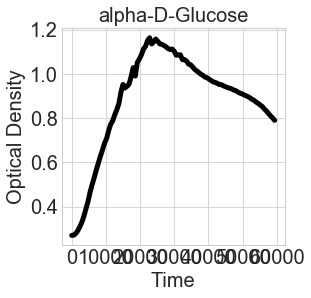

In [79]:
plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

(<matplotlib.figure.Figure at 0x10b55b190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11121e690>)

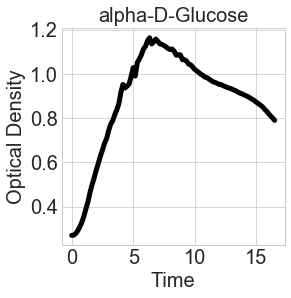

In [80]:
plate.convertTimeUnits()
plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

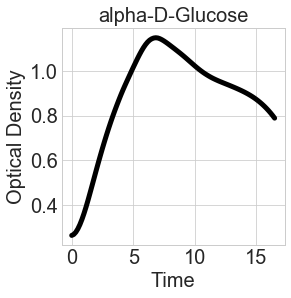

In [82]:
plate.smoothData();
plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

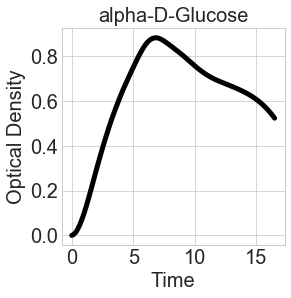

In [83]:
plate.subtractBaseline();
#plate.subtractControl();
plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

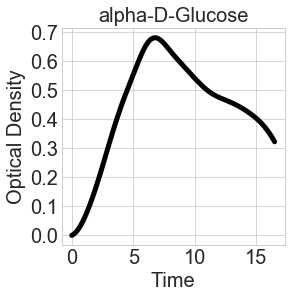

In [88]:
temp = copy.copy(plate)
temp.subtractControl();
temp.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,classical_r,classical_K,classical_d,classical_AUC
Well,,,,,,,,,,,,
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.270162,0.69044,1.096525,10.254478


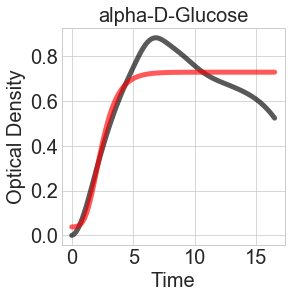

In [116]:
temp = copy.copy(plate)
growth = temp.extractGrowthData({'Substrate':['alpha-D-Glucose']});

model_fit = GrowthMetrics(growth)
model_fit.Classical(gompertz)
model_fit.inferClassicalDynamics()
model_fit.predictClasscial()

model_fit.plot();

model_fit.key

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC
Well,,,,,,,,,,,
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.202244,0.881604,10.298077


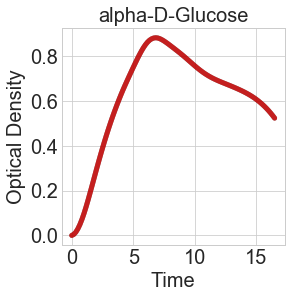

In [117]:
temp = copy.copy(plate)
growth = temp.extractGrowthData({'Substrate':['alpha-D-Glucose']});

model_fit = GrowthMetrics(growth)
model_fit.GP()
model_fit.inferGPDynamics()
model_fit.predictGP()

model_fit.plot();

model_fit.key

In [ ]:
temp = copy.copy(plate)
growth = temp.extractGrowthData({'Substrate':['alpha-D-Glucose']});

model_fit = GrowthMetrics(growth)
model_fit.Classical(gompertz)
model_fit.inferClassicalDynamics()
model_fit.predictClasscial()

model_fit.plot()

In [89]:
growth_summary = pd.DataFrame(index=summary.index,
                              columns=['GP_r','GP_K','GP_AUC',
                                       'classical_r','classical_K','classical_AUC']);
growth_summary.head()

,GP_r,GP_K,GP_AUC,classical_r,classical_K,classical_AUC
Well,,,,,,
A1,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN
C1,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
counter = 0;
row_count = 1; print '%02d' % row_count,
for well in growth_summary.index:

    if counter<12:
        print '.',
        counter += 1;
    else:
        row_count += 1;
        print '\n%02d .' % row_count,
        counter = 1;

    substrate = plate.key.loc[well,'Substrate']; #print substrate
    growth = plate.extractGrowthData({'Substrate':[substrate]});

    model_fit = GrowthMetrics(growth)
    model_fit.Classical(gompertz)
    model_fit.inferClassicalDynamics()
    #model_fit.predictClasscial()

    to_header = ['classical_r','classical_K','classical_AUC'];
    to_index = model_fit.key.index[0]
    growth_summary.loc[to_index,to_header] = model_fit.key.loc[to_index,to_header].values

    model_fit = GrowthMetrics(growth)
    model_fit.GP()
    model_fit.inferGPDynamics()
    #model_fit.predictGP()

    to_header = ['GP_r','GP_K','GP_AUC'];
    to_index = model_fit.key.index[0]
    growth_summary.loc[to_index,to_header] = model_fit.key.loc[to_index,to_header].values


01 .

 /Users/firasmidani/local_applications/miniconda2/envs/qiime1/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning:Covariance of the parameters could not be estimated


 . . . . . . . . . . . 
02 . . . . . . . . . . . . 
03 . . . . . . . . .

 /Users/firasmidani/local_applications/miniconda2/envs/qiime1/lib/python2.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/firasmidani/local_applications/miniconda2/envs/qiime1/lib/python2.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/firasmidani/local_applications/miniconda2/envs/qiime1/lib/python2.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 . . . 
04 . . . . . . . . . . . . 
05 . . . . . . . . . . . . 
06 . . . . . . . . . . . . 
07 . . . . . . . . . . . . 
08 . . . . . . . . . . . .


In [91]:
summary.join(growth_summary)

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,classical_r,classical_K,classical_AUC
Well,,,,,,,,,,,,,,
A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.000000,0.0852779,0.216779,3.01699,0.074291,0.226772,3.00027
B1,B,PRB954_PM1-1,2,1,PRB954,D-Serine,0.212137,0.989620,0.0840382,0.215398,3.04869,0.0809384,0.216689,3.03181
C1,C,PRB954_PM1-1,3,1,PRB954,D-Glucose-6-Phospate,0.216576,1.010329,0.083639,0.218604,2.98662,0.0697046,0.229808,2.96987
D1,D,PRB954_PM1-1,4,1,PRB954,L-Asparagine,0.189050,0.881920,0.0812181,0.19148,2.59332,0.094788,0.169216,2.58067
E1,E,PRB954_PM1-1,5,1,PRB954,L-Glutamine,0.211803,0.988062,0.0865514,0.213982,2.99737,0.0728783,0.228611,2.97956
F1,F,PRB954_PM1-1,6,1,PRB954,Glycyl-L-Aspartic Acid,0.177690,0.828926,0.0771536,0.177191,2.40571,0.0970366,0.155344,2.39381
G1,G,PRB954_PM1-1,7,1,PRB954,Glycyl-LGlutamic Acid,0.179329,0.836570,0.0764504,0.178387,2.26921,0.0967617,0.149596,2.25812
H1,H,PRB954_PM1-1,8,1,PRB954,Glycyl-L-Proline,0.188562,0.879643,0.0815935,0.18437,2.3796,0.10371,0.153263,2.36981
A2,A,PRB954_PM1-1,1,2,PRB954,L-Arabanose,0.214376,1.000066,0.0704432,0.215375,2.94537,0.0583146,0.268532,2.92791
